# Build workflow from scratch
<hr>

In this notebook we present the pyJedAI approach. pyJedAI is a an end-to-end and an upcoming python framework for Entity Resolution that will be a manual of the Entity Resolution. Its usages will outperform other state-of-the-art ER frameworks as it's easy-to-use and highly optimized as it is consisted from other established python libraries (i.e pandas, networkX, ..).

# Instalation

pyJedAI is an open-source library that can be installed from PyPI.

For more: [pypi.org/project/pyjedai/](https://pypi.org/project/pyjedai/)

In [ ]:
!pip install pyjedai -U

In [6]:
!pip show pyjedai

Name: pyjedai
Version: 0.0.3
Summary: An open-source library that builds powerful end-to-end Entity Resolution workflows.
Home-page: 
Author: 
Author-email: Konstantinos Nikoletos <nikoletos.kon@gmail.com>, George Papadakis <gpapadis84@gmail.com>
License: Apache Software License 2.0
Location: c:\users\nikol\appdata\local\programs\python\python310\lib\site-packages
Requires: faiss-cpu, gensim, matplotlib, matplotlib-inline, networkx, nltk, numpy, optuna, pandas, pandas-profiling, pandocfilters, PyYAML, rdflib, rdfpandas, regex, scipy, seaborn, sentence-transformers, strsim, strsimpy, tomli, tqdm, transformers
Required-by: 


# Reading the dataset - Clean-Clean ER example

pyJedAI in order to perfrom needs only the tranformation of the initial data into a pandas DataFrame. Hence, pyJedAI can function in every structured or semi-structured data. In this case Abt-Buy dataset is provided as .csv files. 

<div align="center">
    <img align="center" src="https://github.com/AI-team-UoA/pyJedAI/blob/main/documentation/reading-process.png?raw=true" width="800" />
</div>


## pyjedai <Data\> module

Data module offers a numpber of options
- Selecting the parameters (columns) of the dataframe, in D1 (and in D2)
- Prints a detailed text analysis
- Stores a hidden mapping of the ids, and creates if it is not exist.


In [10]:
import pandas as pd

from pyjedai.datamodel import Data

d1 = pd.read_csv("./../data/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./../data/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./../data/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

data.process()

In [11]:
data.print_specs()

Type of Entity Resolution:  Clean-Clean
Number of entities in D1:  1076
Attributes provided  for D1:  ['id', 'name', 'description']

Number of entities in D2:  1076
Attributes provided  for D2:  ['id', 'name', 'description']

Total number of entities:  2152
Number of matching pairs in ground-truth:  1076


In [12]:
data.dataset_1.head(2)

,id,name,description,price
0,0,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,
1,1,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399


In [13]:
data.dataset_2.head(2)

,id,name,description,price
0,0,Linksys EtherFast EZXS88W Ethernet Switch - EZ...,Linksys EtherFast 8-Port 10/100 Switch (New/Wo...,
1,1,Linksys EtherFast EZXS55W Ethernet Switch,5 x 10/100Base-TX LAN,


In [14]:
data.ground_truth.head(2)

,D1,D2
0,206,216
1,60,46


# Creating workflow using pyJedAI methods

Multiple algorithms, techniques and features have already been implemented. This way, we can import the method and proceed to the workflow architecture.

For example we demostrate a variety of algorithms in each step, as it is shown in the bellow cell.

In [15]:
from pyjedai.workflow import WorkFlow, compare_workflows
from pyjedai.block_building import (
    StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, 
    SuffixArraysBlocking, ExtendedSuffixArraysBlocking
)
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, 
    CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, 
    ReciprocalWeightedNodePruning, ComparisonPropagation
)
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering

## Building a simple WorkFlow

The main workflow that pyjedai supports, consists of 8 steps:

- __Data Reading:__ Raw data in the pandas\<DataFrame\> format are transformed to pyjedai\<Data\>
- __Block Building__: In this step we create blocks of entities based on some tokenization techniques like QGrams, SuffixArray, etc.
- __Block Filtering, Block Purging, Cardnality Edge Pruning__: These methods reduce the amount of comparisons by removing entities from the blocks or producing a much more dence index.    
- __Entity Matching__: The similarity checking phase. Each block is now tested for similarity. Meaning that all entities contained in the block will be mesaured for similarity using a metric like Jaccard.
- __Connected Components Clustering__: Creates clusters of similarity based on the graph produced from the entity matching step.
- __Results__: Finally, pyjedai produces a set of pairs that apper to be duplicates, scores as well as visualizations that help users understand the workflow performance. 

For this demo, we created a simple architecture as we see bellow:


![workflow-example.png](https://github.com/AI-team-UoA/pyJedAI/blob/main/documentation/workflow-example.png?raw=true)

In [16]:
w = WorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=3)
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.8)
        ),
        dict(
            method=BlockPurging,
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
    entity_matching = dict(
        method=EntityMatching, 
        metric='sorensen_dice',
        similarity_threshold=0.5,
        attributes = ['description', 'name']
    ),
    clustering = dict(method=ConnectedComponentsClustering),
    name="Worflow-QGramsBlocking"
)

# Evaluation and detailed reporting

In [17]:
w.run(data, workflow_tqdm_enable=True, verbose=False)

Worflow-QGramsBlocking:   0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
w.to_df()

,Algorithm,F1,Recall,Precision,Runtime (sec),Params
0,Q-Grams Blocking,0.041641,100.000000,0.020825,0.393975,{'Q-Gramms': 3}
1,Block Filtering,0.029729,100.000000,0.014867,0.231038,{'Ratio': 0.8}
2,Block Purging,0.023116,100.000000,0.011559,0.022002,"{'Smoothing factor': 1.025, 'Max Comparisons p..."
3,Cardinality Edge Pruning,3.383632,98.884758,1.721265,3.764078,"{'Node centric': False, 'Weighting scheme': 'JS'}"
4,Entity Matching,3.383632,98.884758,1.721265,34.352360,"{'Metric': 'sorensen_dice', 'Embeddings': None..."
5,Connected Components Clustering,0.176289,99.907063,0.088222,0.003999,{}


# Visualization

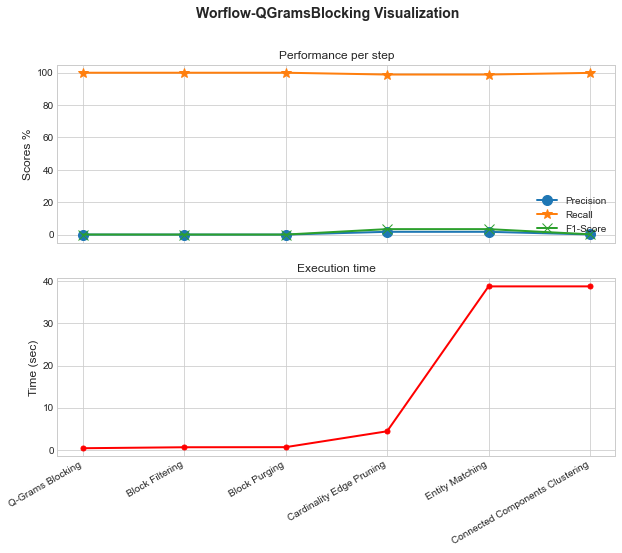

In [24]:
w.visualize()

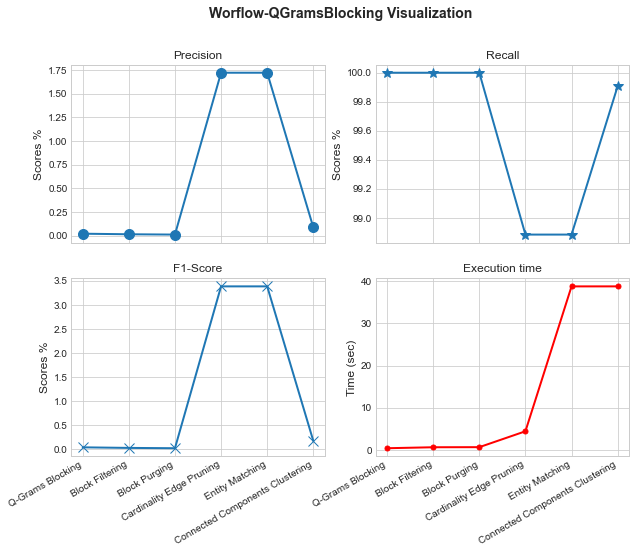

In [20]:
w.visualize(separate=True)

# Multiple workflows

pyJedAI provides methods for comparing multiple workflows. For example, we can test the above example with all the Block Building methods provided.


In [21]:
block_building_methods = [StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking]
workflows = []
for bbm in block_building_methods:
    workflows.append(WorkFlow(
        block_building = dict(
            method=bbm, 
        ),
        block_cleaning = [
            dict(
                method=BlockFiltering, 
                params=dict(ratio=0.8)
            ),
            dict(
                method=BlockPurging,
                params=dict(smoothing_factor=1.025)
            )
        ],
        comparison_cleaning = dict(method=CardinalityEdgePruning),
        entity_matching = dict(
            method=EntityMatching,
            metric='sorensen_dice',
            similarity_threshold=0.5,
            attributes = ['description', 'name']
        ),
        clustering = dict(method=ConnectedComponentsClustering),
        name="Workflow-"+str(bbm.__name__)
    ))
    workflows[-1].run(data, workflow_tqdm_enable=True)

Workflow-StandardBlocking:   0%|          | 0/5 [00:00<?, ?it/s]

Workflow-QGramsBlocking:   0%|          | 0/5 [00:00<?, ?it/s]

Workflow-ExtendedQGramsBlocking:   0%|          | 0/5 [00:00<?, ?it/s]

Workflow-SuffixArraysBlocking:   0%|          | 0/5 [00:00<?, ?it/s]

Workflow-ExtendedSuffixArraysBlocking:   0%|          | 0/5 [00:00<?, ?it/s]

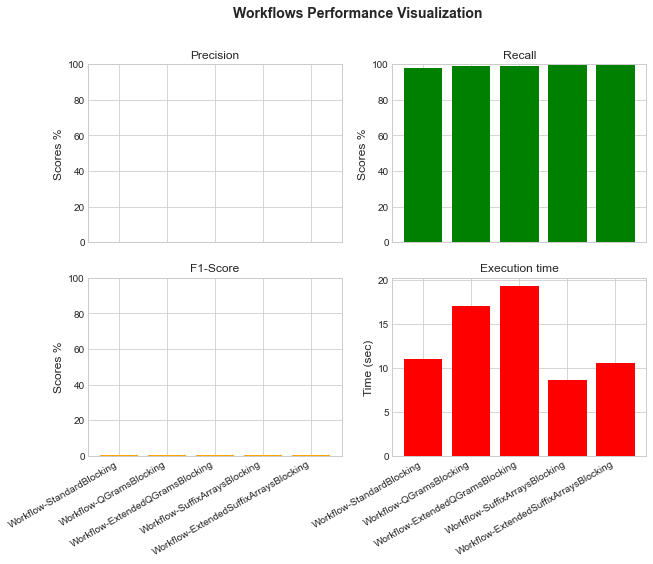

,Name,F1,Recall,Precision,Runtime (sec)
0,Workflow-StandardBlocking,0.197932,97.862454,0.099066,10.967764
1,Workflow-QGramsBlocking,0.182086,98.884758,0.091127,17.006940
2,Workflow-ExtendedQGramsBlocking,0.181989,98.791822,0.091078,19.250524
3,Workflow-SuffixArraysBlocking,0.183603,99.814126,0.091886,8.559587
4,Workflow-ExtendedSuffixArraysBlocking,0.183203,99.907063,0.091685,10.580076


In [22]:
compare_workflows(workflows, with_visualization=True)

<hr>
<div align="right">
K. Nikoletos, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>